In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

Single Variable Calculus

In [7]:
# precision and domain data
epst = 0.01;
epsy = 10**(-6);
tmin = -1.;
tmax = 1.;
num_tvals = int(math.ceil((tmax - tmin)/epst));
tvals = np.arange(tmin, tmax + epst, epst);
tvals[-1] = tmax;

In [14]:
# calculus with tables of values over tvals
def table(func):
    # returns a table of the function's values at each t value
    return func(tvals)

def plot_from_table(tab):
    # plots the function 
    plt.plot(tvals, tab, 'r')
    plt.show()

def derivative_table(tab):
    # returns the derivative's table
    # since we only use tvals, it is less precise at the endpoints
    vals = np.array([(tab[i + 1] - tab[i - 1])/(2 * epst) for i in np.delete(range(len(tab)), [0, -1])])
    return np.concatenate((np.array([(tab[1] - tab[0])/(epst)]),  vals, np.array([(tab[-1] - tab[-2])/epst])), 0)

def antiderivative_table(tab, t0, y0):
    # integrates the function from the table and  guarantees that F(t0) = y0
    # calculate the antiderivative F such that F(tmin) = 0 (i.e. integrate from tmin)
    yvals = [0]
    y = 0
    for i in range(num_tvals):
        # print(y)
        y += (tab[i] + tab[i + 1])/2 * epst
        yvals.append(y)

    Ft0 = func_from_table(yvals)(t0)
    yvals = np.array(yvals) + y0 - Ft0
    return np.array(yvals)

def ODE_IVP(expr, t0, y0):
    # attempts to numerically solve the ODE y' = expr, where expr = F(t, y), y(t0) = y0
    # enter expr as a function of t & y, t0 & y0 are reals
    # returns a table of values of y or prints that there is an error
    try:
        # big idea: work forward and backward from t0, over two separate lists
        # 
        upper_index = list(map(lambda a: a >= t0, tvals)).index(1)
        tfor = tvals[upper_index:] #tvals going forward from t0
        tback = tvals[:upper_index] # tvals going backward
        dist = (t0 - tvals[upper_index - 1])  #distance to lower tm -> 1 - t is dist to tM
        expr0 = expr(t0, y0) # derivative at (t0, y0)
        ym, yM= y0 - dist * expr0, y0 + (epst - dist) * expr0 # usual linear approximation
        yfor, yback = [yM], [ym]
        for i in range(len(tfor) - 1):
            yfor.append(yfor[-1] + expr(tfor[i], yfor[i]) * epst)
        for i in range(len(tback) - 1):
            yback.insert(0, yback[0] - expr(tback[-i - 1], yback[-i - 1]) * epst)
        yvals = np.array(yback + yfor)
    except:
        print('We could not solve your ODE.  See if you entered valid initial conditions.')
    else:
        return yvals
        
def Newton (func, t0, num_tries=20, precision=epsy):
    # Uses Newton's method to solve the equation func == 0, beginning at the guess t = t0
    def next(t): # find the next term in the 
        return t - func(t)/ derivative_func(func)(t)
    try:
        seq = [t0]
        for i in range(num_tries):
            seq.append(next(seq[-1]))
            if abs(func(seq[-1])) < precision:
                
                print(f'We believe the value t = {seq[-1]} solves your equation.')
                print(f'It took {i + 1} tries.')
                break
    except:
        print('We were unable to solve your equation in the number of tries specified.')
        print('Try again with a different guess or more tries.')
    else:
        return seq[-1]

# calculus with functions 
def func_from_table(tab):
    # use weighted sums to approximate values of a function based on a table
    def func(t):
        # make sure t is in our domain
        if tmin <= t <= tmax:
            if t == tmin:
                # then just use the value in the table
                return tab[0]
            else:
                # since t might not be in tvals, we use weights to approximate the value of f(t)
                # first we pinpoint which values in tval are closest to t: tm < t <= tM
                upper_index = list(map(lambda a: a >= t, tvals)).index(1)
                # then we find how close it is to each of the two values and scale by epst to get weights
                dist = (t - tvals[upper_index - 1])/epst
                # then we take the weighted average of F(t) = (1 - t) F(tm) + t F(tM)
                avg = (1 - dist) * tab[upper_index - 1] + dist * tab[upper_index]
                return avg
        else:
            print("Please choose a basepoint in the domain")
            return False
    return func

def plot_from_func(func):
    # plots the function 
    t, y = tvals, list(map(func, tvals))
    plt.plot(t, y, 'r')
    plt.show()
           
def derivative_func(func):
    # returns the derivative function
    return lambda t: (func(t + epst)- func(t - epst))/(2 * epst)   

def antiderivative_func(func, t0, y0):
    return func_from_table(antiderivative_table(table(func), t0, y0)) 
                                                                                   

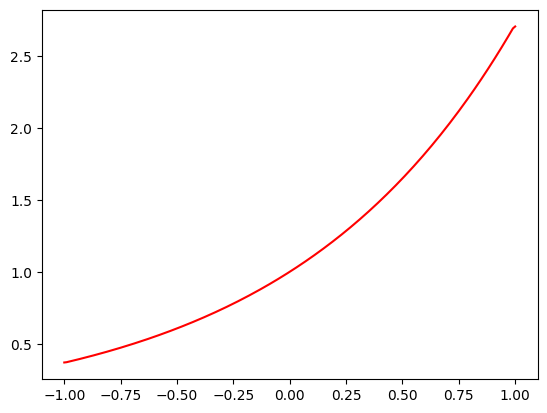

We believe the value t = 0.6931475967731197 solves your equation.
It took 3 tries.


0.6931475967731197

In [20]:
f = lambda x: math.e**x - 2
f_tab = table(f)
df_tab = derivative_table(f_tab)
plot_from_table(df_tab)
Newton(f, 1)

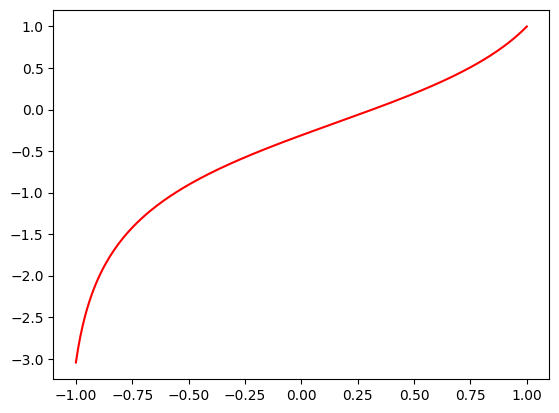

In [26]:
F = lambda x, y: math.e**(x * y)
ODE_sol = ODE_IVP(F, 1, 1)
plot_from_table(ODE_sol)

Multivariate Calculus

In [27]:
# run this first
def cartesian_product(*arrays):
    # credit to senderle on stackoverflow
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
        # return arr.reshape(-1, la)
    return arr

def map_level(f, arr, level):
    # credit to Eric on stackoverflow, adapted to arrays
    # print(arr)
    im = []
    if level == 0:
        return f(arr)
    else:
        for i in arr:
            im.append(map_level(f, i, level - 1))
        return im

    
epst = .1;
epsy = 10**(-6);
tmin = np.array([-1, -1, -1]); # lower bounds for each variable
tmax = np.array([1, 0, 3]); # upper bounds, must be same amount as tmin
m = len(tmin)
num_tvals = [int(math.ceil((tmax[i] - tmin[i])/epst)) for i in range(m)];
tvals0 = [np.arange(tmin[i] , tmax[i] + epst, epst) for i in range(m)]
for i in range(m):
    tvals0[i][-1] = tmax[i]
tvals = cartesian_product(*tuple(tvals0))

In [31]:
# calculus with tables of values over tvals
def table_mult(func):
    # reads a list of functions and maps each to the lattice of t values
    return np.array(map_level(func, tvals, m))


def partial_table(tab, var):
    # returns a table of partial derivatives with respect to the variable t[var]
    axes_list = list(range(m + 1))
    axes_list[var], axes_list[m - 1] = m - 1, var
    new_tab = np.transpose(tab, tuple(axes_list))
    der = map_level(derivative_table, new_tab, m - 1)
    return np.transpose(der, tuple(axes_list))

def jacobian(tab):
    shape_list = list(tab.shape)
    shape_list.insert(-1, 1)
    new_shape = tuple(shape_list)
    arr_list = []
    for i in range(m):
        par = partial_table(tab, i)
        arr_list.append(np.reshape(partial_table(tab, i), new_shape))
    return np.concatenate(tuple(arr_list), m)


                                                                                   

In [34]:
f = lambda t: [t[0] * t[2], t[1]**2]
f_tab = table_mult(f)
jacobian(f_tab)[1, 1, 1]

array([[-0.9,  0. ],
       [ 0. , -1.8],
       [-0.9,  0. ]])